In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [171]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode"])

In [172]:
df.set_index("Report_TransactionEffectiveDate", inplace=True)

In [173]:
credit_df = df[df["TransactionGroup"] == "C"].groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D')
debit_df = df[df["TransactionGroup"] == "D"].groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D')

In [174]:
credit_df = credit_df.ffill().bfill()
debit_df = debit_df.fillna(0)

In [175]:
credit_df_prophet = credit_df.reset_index()
credit_df_prophet.columns = ['ds', 'y']

debit_df_prophet = debit_df.reset_index()
debit_df_prophet.columns = ['ds', 'y']

debit_df_prophet

,ds,y
0,2013-12-30,-1204.344198
1,2013-12-31,-68615.496671
2,2014-01-01,-3465.890925
3,2014-01-02,-68854.006609
4,2014-01-03,-31164.467846
...,...,...
2554,2020-12-27,0.000000
2555,2020-12-28,0.000000
2556,2020-12-29,-33968.719814
2557,2020-12-30,-35533.549603


In [176]:
credit_model = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True,
    daily_seasonality=False,  
    seasonality_mode='additive'  
)
credit_model.fit(credit_df_prophet)

16:53:54 - cmdstanpy - INFO - Chain [1] start processing
16:53:54 - cmdstanpy - INFO - Chain [1] done processing


In [177]:
debit_model = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True,
    daily_seasonality=False,  
    seasonality_mode='additive'  
)
debit_model.fit(debit_df_prophet)


16:53:54 - cmdstanpy - INFO - Chain [1] start processing
16:53:54 - cmdstanpy - INFO - Chain [1] done processing


In [178]:
credit_predicted = credit_model.predict(credit_df_prophet)['yhat']
debit_predicted = debit_model.predict(debit_df_prophet)['yhat']

In [179]:
# Calculate evaluation metrics for credit
credit_mae = mean_absolute_error(credit_df_prophet['y'], credit_predicted)
credit_rmse = np.sqrt(mean_squared_error(credit_df_prophet['y'], credit_predicted))

# Calculate evaluation metrics for debit
debit_mae = mean_absolute_error(debit_df_prophet['y'], debit_predicted)
debit_rmse = np.sqrt(mean_squared_error(debit_df_prophet['y'], debit_predicted))


In [180]:
# Print evaluation metrics
print("Credit Model Evaluation:")
print(f"MAE: {credit_mae:.2f}, RMSE: {credit_rmse:.2f}")

print("\nDebit Model Evaluation:")
print(f"MAE: {debit_mae:.2f}, RMSE: {debit_rmse:.2f}")

Credit Model Evaluation:
MAE: 12229.45, RMSE: 17097.24

Debit Model Evaluation:
MAE: 9266.33, RMSE: 14625.71


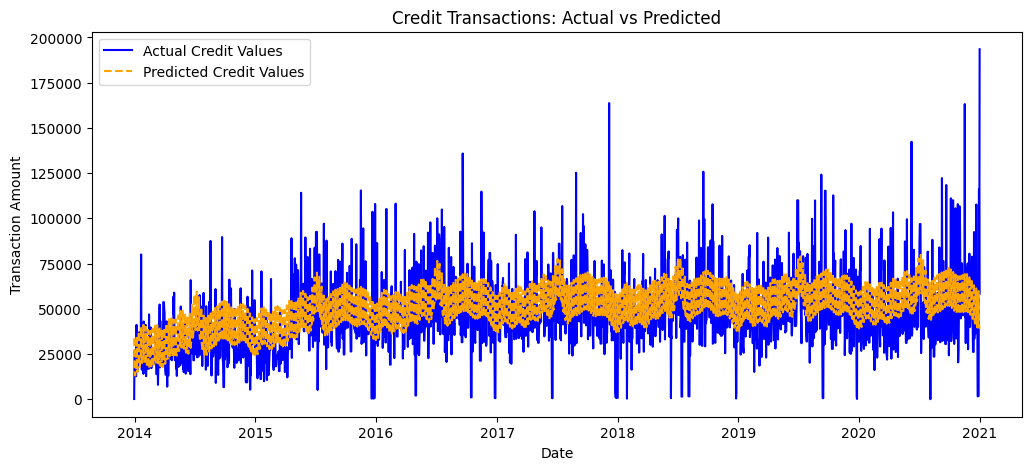

In [181]:
plt.figure(figsize=(12, 5))
plt.plot(credit_df_prophet['ds'], credit_df_prophet['y'], label='Actual Credit Values', color='blue')
plt.plot(credit_df_prophet['ds'], credit_predicted, label='Predicted Credit Values', color='orange', linestyle='--')
plt.title('Credit Transactions: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()


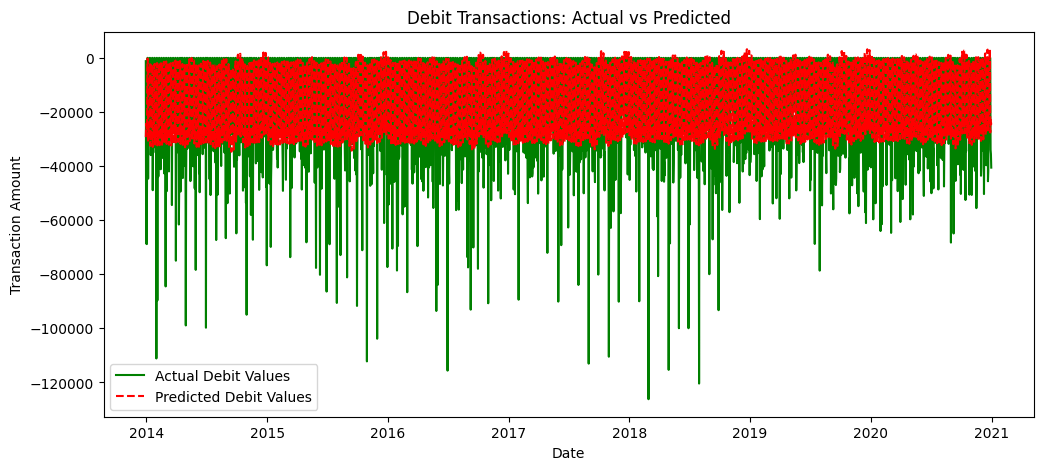

In [182]:
# Plot actual vs predicted values for debit
plt.figure(figsize=(12, 5))
plt.plot(debit_df_prophet['ds'], debit_df_prophet['y'], label='Actual Debit Values', color='green')
plt.plot(debit_df_prophet['ds'], debit_predicted, label='Predicted Debit Values', color='red', linestyle='--')
plt.title('Debit Transactions: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

In [183]:
# Combine credit and debit predictions to evaluate total transactions
total_actual = credit_df_prophet['y'] + debit_df_prophet['y']
total_predicted = credit_predicted + debit_predicted

In [184]:
# Calculate evaluation metrics for total transactions
total_mae = mean_absolute_error(total_actual, total_predicted)
total_rmse = np.sqrt(mean_squared_error(total_actual, total_predicted))

In [185]:
# Print evaluation metrics for total transactions
print("\nTotal Transactions Evaluation:")
print(f"MAE: {total_mae:.2f}, RMSE: {total_rmse:.2f}")


Total Transactions Evaluation:
MAE: 14898.15, RMSE: 20579.13


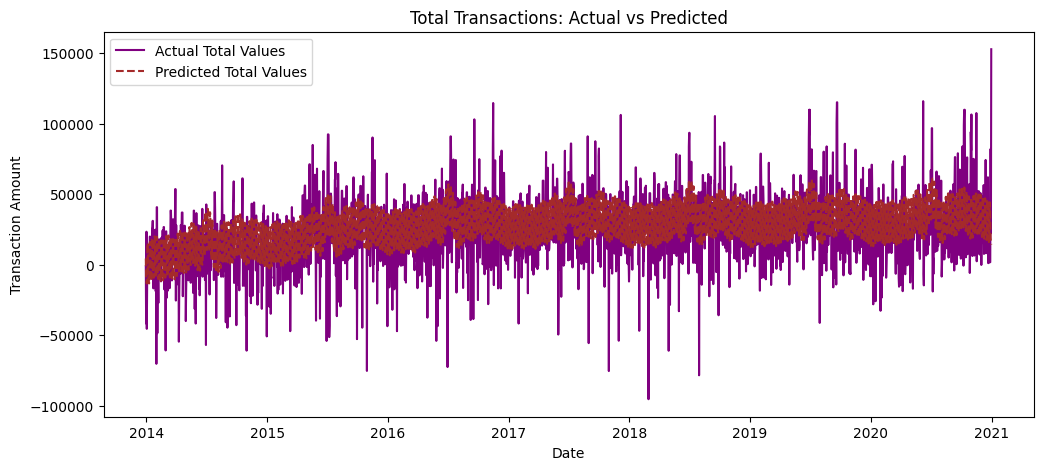

In [186]:
# Plot actual vs predicted values for total transactions
plt.figure(figsize=(12, 5))
plt.plot(credit_df_prophet['ds'], total_actual, label='Actual Total Values', color='purple')
plt.plot(credit_df_prophet['ds'], total_predicted, label='Predicted Total Values', color='brown', linestyle='--')
plt.title('Total Transactions: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show() 

In [187]:
future = credit_model.make_future_dataframe(periods=90, freq='D')  # Create future DataFrame for 90 days

# Generate forecasts for credit and debit
credit_forecast = credit_model.predict(future)
debit_forecast = debit_model.predict(future)

In [188]:
# Sum the forecasts to get the total forecast
total_forecast = credit_forecast[['ds', 'yhat']].copy()
total_forecast['yhat'] = credit_forecast['yhat'] + debit_forecast['yhat']

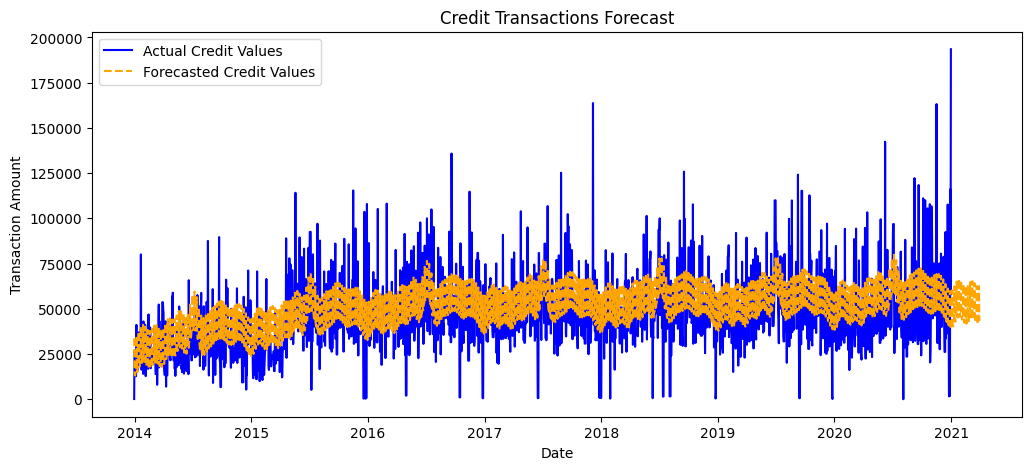

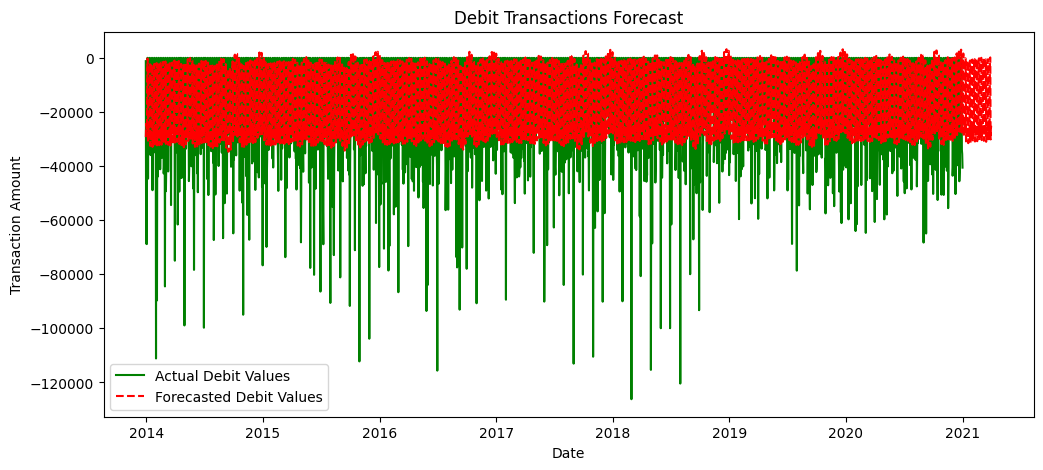

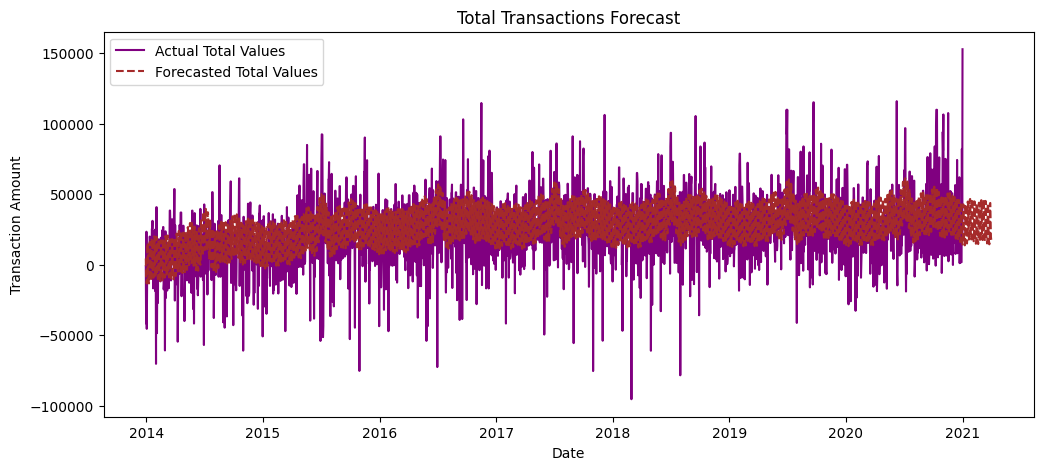

In [189]:
# Plot the forecasts
plt.figure(figsize=(12, 5))
plt.plot(credit_df_prophet['ds'], credit_df_prophet['y'], label='Actual Credit Values', color='blue')
plt.plot(credit_forecast['ds'], credit_forecast['yhat'], label='Forecasted Credit Values', color='orange', linestyle='--')
plt.title('Credit Transactions Forecast')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(debit_df_prophet['ds'], debit_df_prophet['y'], label='Actual Debit Values', color='green')
plt.plot(debit_forecast['ds'], debit_forecast['yhat'], label='Forecasted Debit Values', color='red', linestyle='--')
plt.title('Debit Transactions Forecast')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(credit_df_prophet['ds'], total_actual, label='Actual Total Values', color='purple')
plt.plot(total_forecast['ds'], total_forecast['yhat'], label='Forecasted Total Values', color='brown', linestyle='--')
plt.title('Total Transactions Forecast')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()